## Import libraries etc.

In [1]:
# Import Pandas, Numpy and SQL-Connection
import numpy as np
import pandas as pd

# Import ML- and statistic tools
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from math import sqrt
    
# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# Import pickleshare
from pickleshare import *

### ROC-AUC Confidence interval calculation

In [2]:
def roc_auc_ci(
        y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (round(lower, 2), round(upper, 2))

## Load observation period and fluid cutoff value

In [3]:
%store -r fluid_period
%store -r fluid_cutoff
print('Fluid period: ', fluid_period / 24 / 60 / 60 / 1000, 'days', '/', fluid_period / 60 / 60 / 1000, 'hours')
print('Fluid cutoff: ', fluid_cutoff)

Fluid period:  1.0 days / 24.0 hours
Fluid cutoff:  4350.0


## Unpickle data

In [4]:
intake_df = pd.read_pickle("../data/intake_df.pkl")

## Split DataFrame

### Split dataframes in restrictive / liberal

In [5]:
# Restrictive fluid intake
intake_res_df = intake_df[(intake_df['fluidlib'] == 0)]

# Liberal fluid intake
intake_lib_df = intake_df[(intake_df['fluidlib'] == 1)]

### Split dataframes in survivors / non-survivors

In [6]:
res_survived = len(intake_res_df[intake_res_df['died90'] == 0])
res_died90 = len(intake_res_df[intake_res_df['died90'] == 1])
lib_survived = len(intake_lib_df[intake_lib_df['died90'] == 0])
lib_died90 = len(intake_lib_df[intake_lib_df['died90'] == 1])

## Statistics
- res*: Restrictive fluid intake
- lib*: Liberal fluid intake
- *survived: Survived more than 90 days after admission
- *died90: Died within 90 days after admission

### Demography

In [7]:
sex_unknown_res = len(intake_res_df[(intake_res_df['gender'] != 'Vrouw') & (intake_res_df['gender'] != 'Man')])
sex_female_res = len(intake_res_df[intake_res_df['gender'] == 'Vrouw'])
sex_male_res = len(intake_res_df[intake_res_df['gender'] == 'Man'])
sex_unknown_lib = len(intake_lib_df[(intake_lib_df['gender'] != 'Vrouw') & (intake_lib_df['gender'] != 'Man')])
sex_female_lib = len(intake_lib_df[intake_lib_df['gender'] == 'Vrouw'])
sex_male_lib = len(intake_lib_df[intake_lib_df['gender'] == 'Man'])

In [8]:
print('Restrictive')
print('Male:', sex_male_res, '(%s%%)'% round((sex_male_res / (sex_male_res + sex_female_res + sex_unknown_res)) * 100, 1))
print('Female:', sex_female_res, '(%s%%)'% round((sex_female_res / (sex_male_res + sex_female_res + sex_unknown_res)) * 100, 1))
print('Unknown:', sex_unknown_res, '(%s%%)'% round((sex_unknown_res / (sex_male_res + sex_female_res + sex_unknown_res)) * 100, 1))
print('Liberal')
print('Male:', sex_male_lib, '(%s%%)'% round((sex_male_lib / (sex_male_lib + sex_female_lib + sex_unknown_lib)) * 100, 1))
print('Female:', sex_female_lib, '(%s%%)'% round((sex_female_lib / (sex_male_lib + sex_female_lib + sex_unknown_lib)) * 100, 1))
print('Unknown:', sex_unknown_lib, '(%s%%)'% round((sex_unknown_lib / (sex_male_lib + sex_female_lib + sex_unknown_lib)) * 100, 1))

Restrictive
Male: 255 (54.4%)
Female: 205 (43.7%)
Unknown: 9 (1.9%)
Liberal
Male: 420 (61.2%)
Female: 236 (34.4%)
Unknown: 30 (4.4%)


In [9]:
print('Restrictive median intake (IQR):', round(intake_res_df['total_fluids'].median()), \
      '(%s'% round(intake_res_df['total_fluids'].describe().iloc[4]), '-', \
      '%s)'% round(intake_res_df['total_fluids'].describe().iloc[6]))
print('Restrictive median norepinephrine intake in microgram (IQR):', round(intake_res_df['norepi_mcg'].median()), \
      '(%s'% round(intake_res_df['norepi_mcg'].describe().iloc[4]), '-', \
      '%s)'% round(intake_res_df['norepi_mcg'].describe().iloc[6]))
print('Restrictive median norepinephrine initiation time:', round(intake_res_df['norepi_init_time'].median()), \
      '(%s'% round(intake_res_df['norepi_init_time'].describe().iloc[4]), '-', \
      '%s)'% round(intake_res_df['norepi_init_time'].describe().iloc[6]))
print('Restrictive median norepinephrine max dose:', round(intake_res_df['norepi_max_dose'].median()), \
      '(%s'% round(intake_res_df['norepi_max_dose'].describe().iloc[4]), '-', \
      '%s)'% round(intake_res_df['norepi_max_dose'].describe().iloc[6]))
print('Liberal median intake (IQR):', round(intake_lib_df['total_fluids'].median()), \
      '(%s'% round(intake_lib_df['total_fluids'].describe().iloc[4]), '-', \
      '%s)'% round(intake_lib_df['total_fluids'].describe().iloc[6]))
print('Liberal median norepinephrine intake in microgram (IQR):', round(intake_lib_df['norepi_mcg'].median()), \
      '(%s'% round(intake_lib_df['norepi_mcg'].describe().iloc[4]), '-', \
      '%s)'% round(intake_lib_df['norepi_mcg'].describe().iloc[6]))
print('Liberal median norepinephrine initiation time:', round(intake_lib_df['norepi_init_time'].median()), \
      '(%s'% round(intake_lib_df['norepi_init_time'].describe().iloc[4]), '-', \
      '%s)'% round(intake_lib_df['norepi_init_time'].describe().iloc[6]))
print('Liberal median norepinephrine max dose:', round(intake_lib_df['norepi_max_dose'].median()), \
      '(%s'% round(intake_lib_df['norepi_max_dose'].describe().iloc[4]), '-', \
      '%s)'% round(intake_lib_df['norepi_max_dose'].describe().iloc[6]))
print()
print('Restrictive survived > 90d: ', res_survived, "(%s%%)"% round((res_survived / (res_survived + res_died90)) * 100, 1))
print('Restrictive survived < 90d: ', res_died90, "(%s%%)"% round((res_died90 / (res_survived + res_died90)) * 100, 1))
print('Liberal survived > 90d:', lib_survived, "(%s%%)"% round((lib_survived / (lib_survived + lib_died90)) * 100, 1))
print('Liberal survived < 90d: ', lib_died90, "(%s%%)"% round((lib_died90 / (lib_survived + lib_died90)) * 100, 1))

Restrictive median intake (IQR): 2999 (2245 - 3696)
Restrictive median norepinephrine intake in microgram (IQR): 13170 (4400 - 29770)
Restrictive median norepinephrine initiation time: 4440000 (2160000 - 10050000)
Restrictive median norepinephrine max dose: 1 (1 - 3)
Liberal median intake (IQR): 6303 (5316 - 8036)
Liberal median norepinephrine intake in microgram (IQR): 28815 (12552 - 56075)
Liberal median norepinephrine initiation time: 5520000 (2580000 - 12060000)
Liberal median norepinephrine max dose: 2 (1 - 4)

Restrictive survived > 90d:  256 (54.6%)
Restrictive survived < 90d:  213 (45.4%)
Liberal survived > 90d: 365 (53.2%)
Liberal survived < 90d:  321 (46.8%)


In [10]:
intake_lib_df['norepi_max_dose'].describe()

count    665.000000
mean       3.558150
std        5.733601
min        0.100000
25%        1.200000
50%        2.400000
75%        4.000000
max       84.000000
Name: norepi_max_dose, dtype: float64

In [11]:
intake_res_df['norepi_max_dose'].describe()

count    451.000000
mean       2.291885
std        2.749114
min        0.040000
25%        0.700000
50%        1.400000
75%        3.000000
max       24.000000
Name: norepi_max_dose, dtype: float64

In [12]:
intake_res_df['norepi_max_dose'].describe()

count    451.000000
mean       2.291885
std        2.749114
min        0.040000
25%        0.700000
50%        1.400000
75%        3.000000
max       24.000000
Name: norepi_max_dose, dtype: float64

In [13]:
sex_unkown = len(intake_df[(intake_df['gender'] != 'Vrouw') & (intake_df['gender'] != 'Man')])
sex_female = len(intake_df[intake_df['gender'] == 'Vrouw'])
sex_male = len(intake_df[intake_df['gender'] == 'Man'])

### ROC AUC

In [14]:
# Area under curve score is calculated using sklearn.metrics
# Youden index is calculated as the maximal value of true positive rate (tpr) - false positive rate (fpr) 
# (= 1 - specificity)

auc90_fluids = roc_auc_score(intake_df['died90'], intake_df['total_fluids'])
fpr90_fluids, tpr90_fluids, thresholds90_fluids = roc_curve(intake_df['died90'], intake_df['total_fluids'])
optimal_cutoff_pos90_fluids = np.argmax(tpr90_fluids - fpr90_fluids)
optimal_cutoff90_fluids = thresholds90_fluids[optimal_cutoff_pos90_fluids]
youden_index90_fluids = (tpr90_fluids - fpr90_fluids)[optimal_cutoff_pos90_fluids]
auroc_ci90_fluids = roc_auc_ci(intake_df['died90'], intake_df['total_fluids'])
sensitivity90_fluids = tpr90_fluids[optimal_cutoff_pos90_fluids]
specificity90_fluids = 1-fpr90_fluids[optimal_cutoff_pos90_fluids]

print('Observation period:', fluid_period / (24 * 60 * 60 * 1000), 'days')
print()
print('Fluids AUROC 90-day mortality:', round(auc90_fluids, 2))
print('Fluids AUROC 90-day mortality confidence interval:', auroc_ci90_fluids)

Observation period: 1.0 days

Fluids AUROC 90-day mortality: 0.52
Fluids AUROC 90-day mortality confidence interval: (0.49, 0.56)


## Plotting

### AUROC

In [15]:
fpr90_fluids_df = pd.DataFrame({'fpr90_fluids': fpr90_fluids}).melt(var_name = 'fpr', value_name = 'fpr_val')
tpr90_fluids_df = pd.DataFrame({'tpr90_fluids': tpr90_fluids}).melt(var_name = 'tpr', value_name = 'tpr_val')
auc_values_lf = fpr90_fluids_df.join(tpr90_fluids_df)

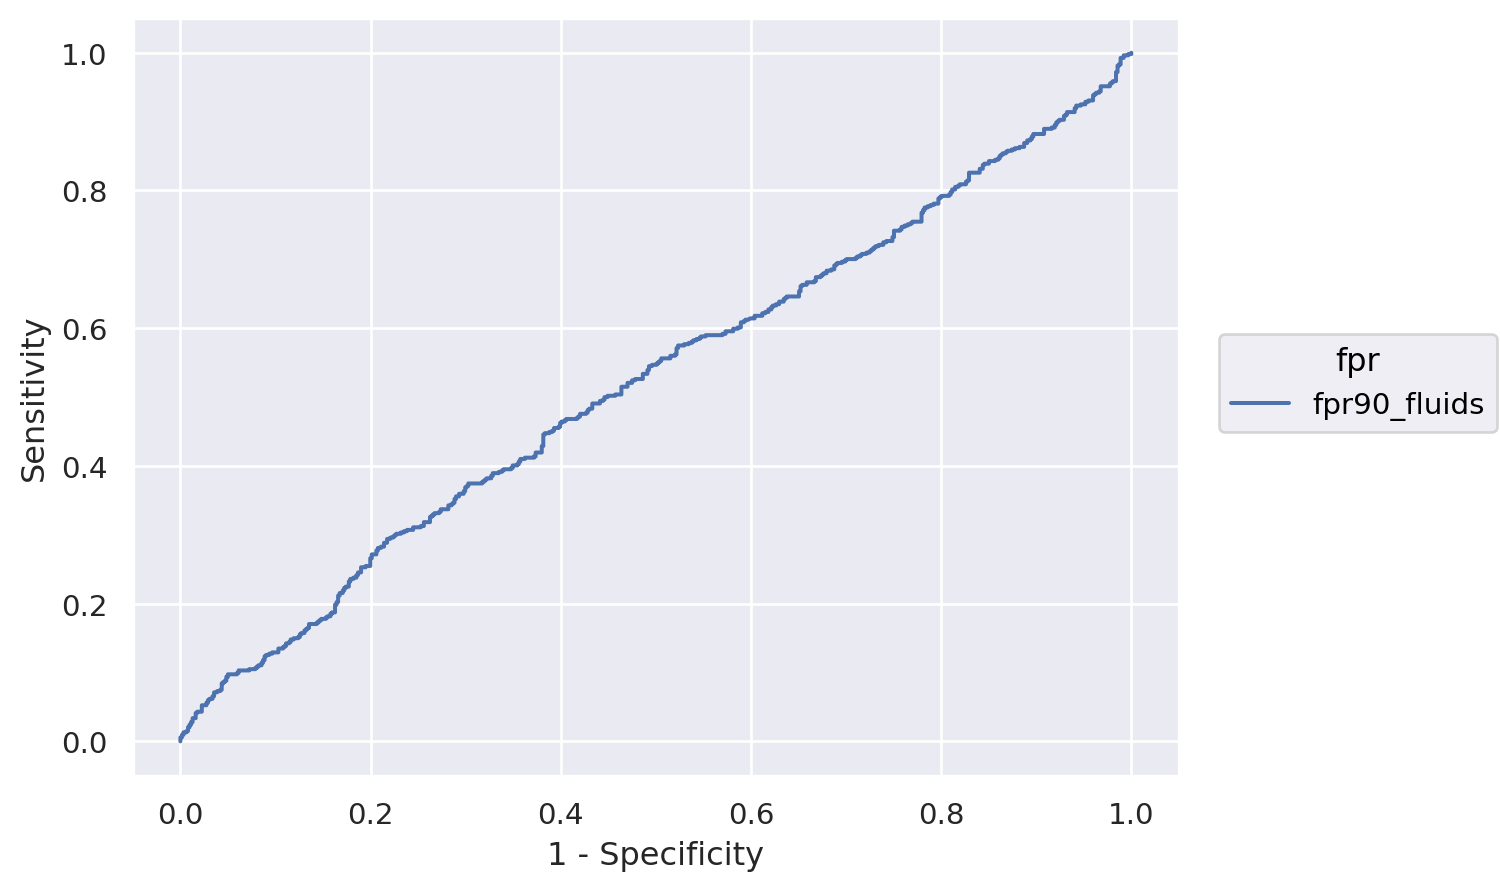

In [16]:
(
    so.Plot(auc_values_lf, x='fpr_val', y='tpr_val', color='fpr')
    .add(so.Line())
    .label(x = '1 - Specificity', y = 'Sensitivity')
    )